In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw, ImageFilter
import random
from scipy import ndimage
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import math
from collections import Counter

In [2]:
with open('train.json') as json_file:
    data = json.load(json_file)

In [3]:
categories_data = pd.DataFrame(data['categories'])
display(categories_data.style.background_gradient(cmap='Blues', axis=0))

,id,name
0,1,Регистрация (постановка на учет)
1,2,Снятие с учета


In [4]:
annotations_data = pd.DataFrame(data['annotations'])
display(annotations_data.iloc [np.r_[0:7, (len(annotations_data)-7):len(annotations_data),:]].style.background_gradient(cmap='Blues', axis=0))

,id,image_id,category_id,segmentation,bbox,ignore,iscrowd,area
0,0,0,1,[],"[1617, 126, 887, 535]",0,0,474545
1,1,1,1,[],"[1366, 642, 1041, 1158]",0,0,1205478
2,2,2,1,[],"[220, 523, 1158, 687]",0,0,795546
3,3,3,1,[],"[519, 165, 342, 564]",0,0,192888
4,4,3,1,[],"[409, 797, 370, 503]",0,0,186110
5,5,3,2,[],"[25, 174, 312, 533]",0,0,166296
6,6,4,1,[],"[1198, 460, 860, 995]",0,0,855700
2793,2793,1978,2,[],"[1167, 1601, 278, 882]",0,0,245196
2794,2794,1978,1,[],"[644, 1565, 459, 872]",0,0,400248
2795,2795,1979,2,[],"[932, 480, 341, 568]",0,0,193688


In [5]:
registration_annotations_data = annotations_data.loc[annotations_data['category_id']==1]
display(registration_annotations_data.iloc 
        [np.r_[0:7, (len(registration_annotations_data)-7):len(registration_annotations_data),:]].style.background_gradient(cmap='Blues', axis=0))

,id,image_id,category_id,segmentation,bbox,ignore,iscrowd,area
0,0,0,1,[],"[1617, 126, 887, 535]",0,0,474545
1,1,1,1,[],"[1366, 642, 1041, 1158]",0,0,1205478
2,2,2,1,[],"[220, 523, 1158, 687]",0,0,795546
3,3,3,1,[],"[519, 165, 342, 564]",0,0,192888
4,4,3,1,[],"[409, 797, 370, 503]",0,0,186110
6,6,4,1,[],"[1198, 460, 860, 995]",0,0,855700
7,7,5,1,[],"[1169, 1700, 1265, 1274]",0,0,1611610
2789,2789,1976,1,[],"[381, 531, 303, 521]",0,0,157863
2791,2791,1977,1,[],"[856, 624, 499, 859]",0,0,428641
2792,2792,1978,1,[],"[1451, 1632, 459, 852]",0,0,391068


In [6]:
images_data = pd.DataFrame(data['images'])
images_data = images_data.rename(columns={'id': 'image_id'})
display(images_data.iloc [np.r_[0:12, (len(images_data)-7):len(images_data),:]].style.background_gradient(cmap='Blues', axis=0))

,width,height,image_id,file_name
0,2868,1613,0,92100.jpg
1,2631,3508,1,92137.jpg
2,3000,2672,2,92344.jpg
3,901,1600,3,92419.jpg
4,3508,2631,4,92598.jpg
5,2631,3508,5,92587.jpg
6,2448,3264,6,92971.jpg
7,2631,3508,7,93365.jpg
8,1620,2160,8,93465.jpg
9,2631,3508,9,93677.jpg


In [7]:
images_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981 entries, 0 to 1980
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   width      1981 non-null   int64 
 1   height     1981 non-null   int64 
 2   image_id   1981 non-null   int64 
 3   file_name  1981 non-null   object
dtypes: int64(3), object(1)
memory usage: 62.0+ KB


In [8]:
k = 0
for i in range(0, len(images_data)):
    try:
        f = images_data.loc[images_data['image_id'] == i, 'file_name'].iloc[0]
        img = cv2.imdecode(np.fromfile('images/'+ f, dtype=np.uint8), 1)
    except FileNotFoundError:
        print('\u001b[38;5;19m', f'Не найден файл в папке images: {f} image_id = {i}', '\u001b[0m')
        k += 1
        images_data = images_data.loc[images_data['image_id'] != i]

 Не найден файл в папке images: 92419.jpg image_id = 3 
 Не найден файл в папке images: 92587.jpg image_id = 5 
 Не найден файл в папке images: 92971.jpg image_id = 6 
 Не найден файл в папке images: 93365.jpg image_id = 7 
 Не найден файл в папке images: 93465.jpg image_id = 8 
 Не найден файл в папке images: 93677.jpg image_id = 9 
 Не найден файл в папке images: 93909.jpg image_id = 10 
 Не найден файл в папке images: 94671.jpg image_id = 15 
 Не найден файл в папке images: 92477.jpg image_id = 18 
 Не найден файл в папке images: 92698.jpg image_id = 19 
 Не найден файл в папке images: 92066.jpg image_id = 23 
 Не найден файл в папке images: 92059.jpg image_id = 25 
 Не найден файл в папке images: 92055.jpg image_id = 27 
 Не найден файл в папке images: 92125.jpg image_id = 30 
 Не найден файл в папке images: 92122.jpg image_id = 31 
 Не найден файл в папке images: 92121.jpg image_id = 32 
 Не найден файл в папке images: 92086.jpg image_id = 40 
 Не найден файл в папке images: 92083

In [9]:
print('\u001b[38;5;19m', f'Удалили из списка отсутствующие файлы\n Количество отсутствующих файлов изображения: {k}', '\u001b[0m')

 Удалили из списка отсутствующие файлы
 Количество отсутствующих файлов изображения: 1084 


In [10]:
images_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 897 entries, 0 to 1980
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   width      897 non-null    int64 
 1   height     897 non-null    int64 
 2   image_id   897 non-null    int64 
 3   file_name  897 non-null    object
dtypes: int64(3), object(1)
memory usage: 35.0+ KB


In [11]:
list_image_id = images_data['image_id'].tolist()
registration_annotations_data_new = registration_annotations_data
registration_annotations_data_new = registration_annotations_data_new[registration_annotations_data_new.image_id.isin(list_image_id)]

In [12]:
display(registration_annotations_data_new.iloc 
        [np.r_[0:7, (len(registration_annotations_data_new)-7):len(registration_annotations_data_new),:]].style.background_gradient(cmap='Blues', axis=0))

,id,image_id,category_id,segmentation,bbox,ignore,iscrowd,area
0,0,0,1,[],"[1617, 126, 887, 535]",0,0,474545
1,1,1,1,[],"[1366, 642, 1041, 1158]",0,0,1205478
2,2,2,1,[],"[220, 523, 1158, 687]",0,0,795546
6,6,4,1,[],"[1198, 460, 860, 995]",0,0,855700
17,17,11,1,[],"[330, 187, 673, 460]",0,0,309580
18,18,12,1,[],"[648, 99, 491, 323]",0,0,158593
19,19,13,1,[],"[649, 94, 491, 326]",0,0,160066
2783,2783,1971,1,[],"[387, 120, 829, 621]",0,0,514809
2788,2788,1975,1,[],"[170, 175, 568, 326]",0,0,185168
2792,2792,1978,1,[],"[1451, 1632, 459, 852]",0,0,391068


In [13]:
registration_annotations_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030 entries, 0 to 2799
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1030 non-null   int64 
 1   image_id      1030 non-null   int64 
 2   category_id   1030 non-null   int64 
 3   segmentation  1030 non-null   object
 4   bbox          1030 non-null   object
 5   ignore        1030 non-null   int64 
 6   iscrowd       1030 non-null   int64 
 7   area          1030 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 72.4+ KB


In [14]:
for i in list_image_id:
    f = registration_annotations_data_new.loc[registration_annotations_data_new['image_id'] == i]
    area_max = 0
    for index, row in f.iterrows(): 
        a = row['area']
        if a > area_max:
            area_max = row['area']
    a = images_data.loc[images_data['image_id'] == i, 'width'].iloc[0]
    b = images_data.loc[images_data['image_id'] == i, 'height'].iloc[0]
    area_big = a * b
    fraction = math.floor(area_big/area_max)
    if fraction > 23:
        fraction = 23
    images_data.loc[images_data['image_id'] == i, 'fraction'] = fraction

In [15]:
images_data['fraction'] = images_data['fraction'].astype(int)
display(images_data.iloc [np.r_[0:12, (len(images_data)-7):len(images_data),:]].style.background_gradient(cmap='Blues', axis=0))

,width,height,image_id,file_name,fraction
0,2868,1613,0,92100.jpg,9
1,2631,3508,1,92137.jpg,7
2,3000,2672,2,92344.jpg,10
4,3508,2631,4,92598.jpg,10
11,1920,1439,11,94021.jpg,8
12,1284,1140,12,94018.jpg,9
13,1284,1140,13,94001.jpg,9
14,2631,3508,14,94048.jpg,11
16,2631,3508,16,94758.jpg,13
17,2528,3507,17,92168.jpg,19


In [16]:
print(images_data['fraction'].sort_values().unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [17]:
print(len(images_data['fraction'].sort_values().unique()))

23


In [18]:
display(images_data['fraction'].value_counts().to_frame().style.background_gradient(cmap='Blues', axis=0))

,count
fraction,
6,105
7,103
5,77
8,61
20,49
21,47
15,43
9,43
17,41


In [19]:
images_list = []
for i in list_image_id:
    f = images_data.loc[images_data['image_id'] == i, 'file_name'].iloc[0]
    img = cv2.imdecode(np.fromfile('images/'+ f, dtype=np.uint8), 1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img = Image.fromarray(gray, mode=None) 
    fixed_len = 512
    draw = ImageDraw.Draw(img) 
    width, height = img.size
    width = img.size[0] 
    height = img.size[1] 
    if width >= height:
        ratio = (fixed_len+1)/float(img.size[0])
        new_height = int(ratio * img.size[1])
        new_size = (fixed_len+1, new_height)
    else:
        ratio = (fixed_len+1)/float(img.size[1])
        new_width = int(ratio * img.size[0])
        new_size = (new_width, fixed_len+1)
    img = img.resize(new_size)
    sharp_img = img.filter(ImageFilter.SHARPEN)
    img = sharp_img.resize((fixed_len, fixed_len))
    img = np.asarray(img)
    images_list.append(img)

In [20]:
print(len(images_list))

897


In [21]:
print(len(images_data))

897


**Наблюдаем дисбаланс классов. Проведем пересемплирование, дополнив выборки до максимального значения, продублировав изображения.**

In [22]:
data = images_data
data = data.reset_index()

In [23]:
max_count_name = data['fraction'].mode()[0]

max_count = Counter(data['fraction'])[max_count_name]
images_data_k = tuple(images_data['fraction'].tolist())
p = 0
for k in sorted(images_data_k):
 
    count = Counter(data['fraction'])[k]
    data_1 = data.loc[data['fraction'] == k]
    l = 0
    for i in range(1, max_count-count+1):
        df = data_1.iloc [[l]]
        data=pd.concat([data,df],ignore_index=True)   
        f = df.iloc[0]['file_name']
        idx = data[data['file_name'] == f].index
        idx = idx[0]
        images_list.append(images_list[idx])
        l += 1
        if l == len(data_1):
            l = 0

In [24]:
display(data['fraction'].value_counts().to_frame().style.background_gradient(cmap='Blues', axis=0))

,count
fraction,
9,105
21,105
2,105
14,105
22,105
23,105
16,105
17,105
15,105


In [25]:
print(len(data))

2415


In [26]:
print(len(images_list))

2415


In [27]:
data = data['fraction']
data = data.reset_index()
del data['index']

In [28]:
encoder = OneHotEncoder(handle_unknown='ignore') 
encoder_df = pd.DataFrame(encoder.fit_transform(data[['fraction']]).toarray())
data_df = data.join(encoder_df)
data_df.drop('fraction', axis=1, inplace= True )
data_new = data_df.values

In [29]:
print('\u001b[38;5;19m', f'Количество изображений в нашей выборке для обучения = {len(images_list)}', '\u001b[0m')

 Количество изображений в нашей выборке для обучения = 2415 


In [30]:
X = np.array(images_list)/255
X = X.astype('float64')

In [31]:
(X_train, X_test, y_train, y_test) = train_test_split(X, data_new, test_size=0.2, random_state=42)

In [32]:
X_train = X_train.reshape(-1, 512, 512, 1)
X_test = X_test.reshape(-1, 512, 512, 1)

In [33]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(512, 512, 1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(23, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision'])

print(model.summary())

C:\Users\19220\Beorg\work_beorg\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 510, 510, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 255, 255, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 253, 253, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     125,960,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 23)                  │          11,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,995,799 (480.64 MB)

 Trainable params: 125,995,799 (480.64 MB)

 Non-trainable params: 0 (0.00 B)

None


In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train,
          epochs=30,
          validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.1220 - loss: 9.0885 - precision: 0.2032 - val_accuracy: 0.5694 - val_loss: 1.5186 - val_precision: 0.7942
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7835 - loss: 0.8210 - precision: 0.9147 - val_accuracy: 0.8137 - val_loss: 0.8099 - val_precision: 0.9003
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9438 - loss: 0.2399 - precision: 0.9631 - val_accuracy: 0.8344 - val_loss: 0.7227 - val_precision: 0.9007
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9778 - loss: 0.1077 - precision: 0.9799 - val_accuracy: 0.8737 - val_loss: 0.7067 - val_precision: 0.8882
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9902 - loss: 0.0801 - precision: 0.9908 - val_accuracy: 0.8634 - val_loss: 0.6885 - val_precision: 0.8851
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9841 - loss: 0.0884 - precision: 0.9852 - val_accuracy: 0.8634 - val_loss: 0.793

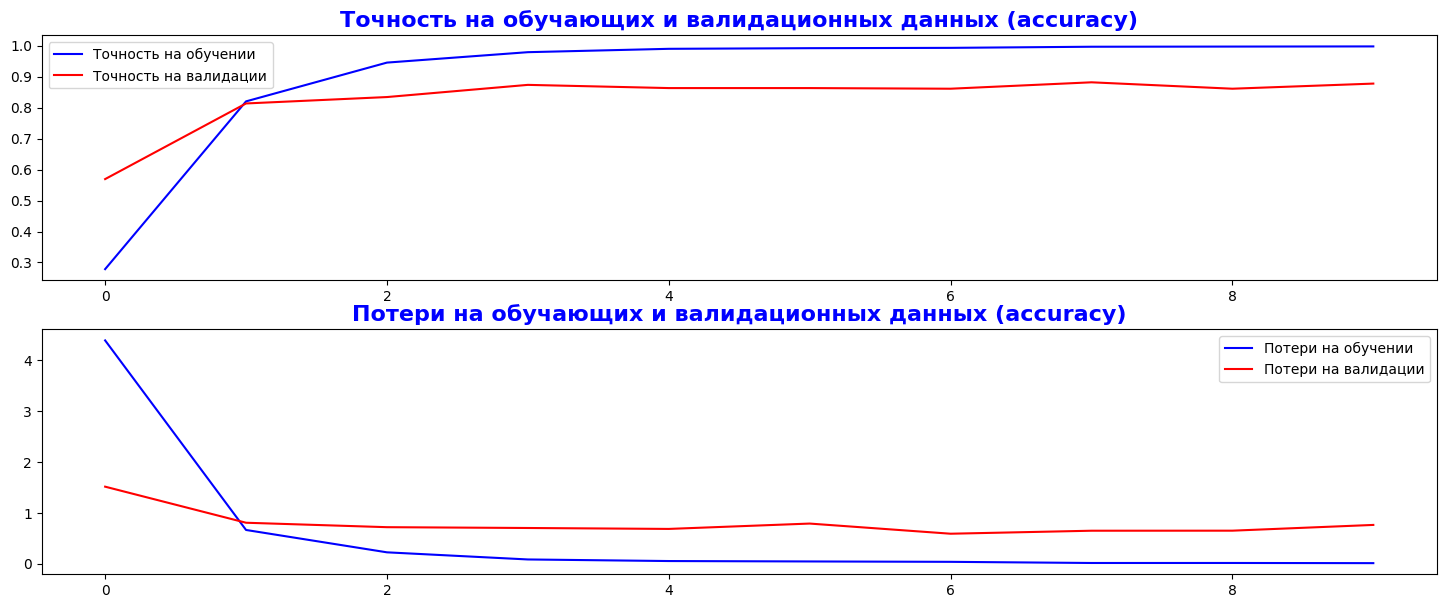

In [35]:
plt.figure(figsize=(18, 7))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label = 'Точность на обучении', color='blue')
plt.plot(history.history['val_accuracy'], label = 'Точность на валидации', color='red')
plt.legend()
plt.title('Точность на обучающих и валидационных данных (accuracy)', fontsize=16, fontweight="bold", color='blue')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label = 'Потери на обучении', color='blue')
plt.plot(history.history['val_loss'], label = 'Потери на валидации', color='red')
plt.legend()
plt.title('Потери на обучающих и валидационных данных (accuracy)', fontsize=16, fontweight="bold", color='blue')
plt.show()

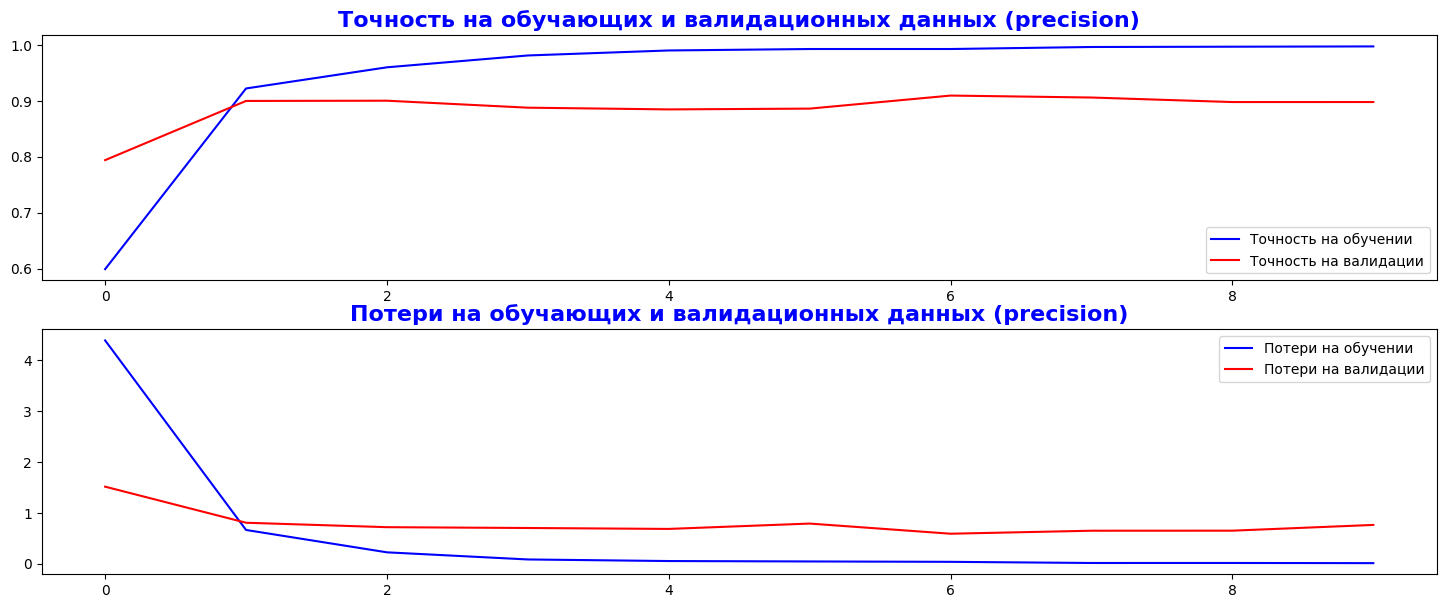

In [36]:
plt.figure(figsize=(18, 7))
plt.subplot(2, 1, 1)
plt.plot(history.history['precision'], label = 'Точность на обучении', color='blue')
plt.plot(history.history['val_precision'], label = 'Точность на валидации', color='red')
plt.legend()
plt.title('Точность на обучающих и валидационных данных (precision)', fontsize=16, fontweight="bold", color='blue')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label = 'Потери на обучении', color='blue')
plt.plot(history.history['val_loss'], label = 'Потери на валидации', color='red')
plt.legend()
plt.title('Потери на обучающих и валидационных данных (precision)', fontsize=16, fontweight="bold", color='blue')
plt.show()

In [37]:
keras.saving.save_model(model, 'model_fraction_area.keras')

In [38]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
auc=history.history['precision']
val_auc=history.history['val_precision']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [39]:
print('\u001b[38;5;19m', 'Точность на обучении max (accuracy) =', round(max(accuracy), 2), '\u001b[0m')

 Точность на обучении max (accuracy) = 1.0 


In [40]:
print('\u001b[38;5;19m', 'Точность на валидации max (accuracy) =', round(max(val_accuracy), 2), '\u001b[0m')

 Точность на валидации max (accuracy) = 0.88 


In [41]:
print('\u001b[38;5;19m', 'Точность на обучении max (precision) =', round(max(auc), 2), '\u001b[0m')

 Точность на обучении max (precision) = 1.0 


In [42]:
print('\u001b[38;5;19m', 'Точность на валидации max (precision) =', round(max(val_auc), 2), '\u001b[0m')

 Точность на валидации max (precision) = 0.91 
